In [1]:
import numpy as np
import networkx as nx
import matplotlib.pylab as plt
import os
import random
import math
import pandas as pd
import scipy
import numpy.ma as ma
import itertools
from networkx.algorithms import bipartite
import community
# from infomap import infomap
import os
import rpy2.robjects as robjects
import copy
from scipy import optimize

In [2]:
def ldata(archive):
    f=open(archive)
    data=[]
    for line in f:
        line=line.strip()
        col=line.split()
        data.append(col)
    return data

In [3]:
data_total=ldata('crimen/red_crimenes')
sexos = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.sex')
nombres = ldata('crimen/moreno_crime/ent.moreno_crime_crime.person.name')
roles = ldata('crimen/moreno_crime/rel.moreno_crime_crime.person.role')

In [4]:
crimenes=[]
personas=[]
red_cr = []
usadosp = []
usadosc = []

for i in data_total:
    if i[1] not in usadosc:
        crimenes.append(i[1]+'cr')
        usadosc.append(i[1])
    if i[0] not in usadosp:
        usadosp.append(i[0])
        personas.append(i[0])
    red_cr.append([i[0],i[1]+'cr']) # En su primer elemento contiene un número que indica a la persona.
                                 # almacenado esto mismo en lista "personas"
                                 # en su segundo elemento un str que contiene al crimen.
                                 # # almacenado esto mismo en lista "crimenes"

### Grafo Bipartito y maxima componente

In [5]:
B = nx.Graph()
B = B.to_undirected()
# Asigna dos valores de bipartición (0 y 1) para cada tipo de nodo (personas, crimenes)
B.add_nodes_from(personas, bipartite=0)
B.add_nodes_from(crimenes, bipartite=1)
# Agrega un enlace entre nodos de biparticiones diferentes.
B.add_edges_from(red_cr)

# plt.figure(figsize=(15,15))
# nx.draw(B,node_size = 40,with_labels=False, font_weight='bold')
# plt.show()

Bmax = max(nx.connected_component_subgraphs(B), key=len)
Bmax = Bmax.to_undirected()
# plt.figure(figsize=(15,15))
# nx.draw(Bmax,node_size = 40,with_labels=False, font_weight='bold')
# plt.show()

#### Atributos

In [6]:
#Asignacion universal de atributos (AUA)
for i in range(2):
    if '1' in bipartite.sets(Bmax)[i]:
        
        for node in bipartite.sets(Bmax)[i]:
            Bmax.node[node]['color']='red'
            Bmax.node[node]['nombre']=nombres[int(node)-1]
            Bmax.node[node]['sexo']=sexos[int(node)-1]
    else:
        for node in bipartite.sets(Bmax)[i]:
            Bmax.node[node]['color']='blue'

for edge in Bmax.edges:
    if [str(edge[0]),str(edge[1])] in red_cr:
        Bmax.edges[edge]['rol']=roles[red_cr.index([str(edge[0]),str(edge[1])])]
    else:
        Bmax.edges[edge]['rol']=roles[red_cr.index([str(edge[1]),str(edge[0])])]

In [7]:
len(bipartite.sets(Bmax)[0])

754

In [8]:
# plt.figure(figsize=(20,20))
# nx.draw_networkx(Bmax, node_color=list(nx.get_node_attributes(Bmax, "color").values()),
#                  node_size=100,
#                  width=1,
#                  alpha=0.8,
#                  with_labels=False)
# plt.show()

### Grafo persona - persona

In [50]:
PP = max(nx.connected_component_subgraphs(nx.algorithms.bipartite.projection.weighted_projected_graph(B, personas, ratio=False)), key=len)
PP = PP.to_undirected()
nx.write_gexf(PP,'PP.gexf')
for node in PP.nodes:
    if node in personas:
#         print("hola")
        PP.node[node]['color']='red'
        PP.node[node]['nombre']=nombres[int(node)-1]
#         PP.node[node]['rol']=roles[node-1]
        PP.node[node]['sexo']=sexos[int(node)-1]
    elif node in crimenes:
#         print('FUNCIONA!!!')
        PP.node[node]['color']='blue'

# plt.figure(figsize=(20,20))
# nx.draw_networkx(PP, node_color=list(nx.get_node_attributes(PP, "color").values()),
#                  node_size=80,
#                  alpha=0.8,
#                  with_labels=False)
# plt.show()

#### Distribucion de grado en grafo bipartito

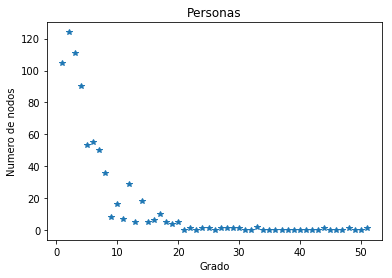

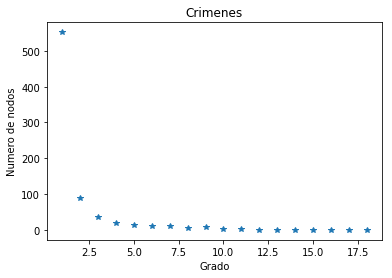

In [75]:
grados = nx.bipartite.degrees(Bmax, list(Bmax.nodes()), weight=None)
gpers=[]
gcrim = []
for node in Bmax.nodes:
    if node in personas:
        gpers.append(grados[1][node])
    if node in crimenes:
        gcrim.append(grados[1][node])

plt.plot(nro,gradpers,'*')
# plt.xscale('log')
# plt.yscale('log')
plt.xlabel('Grado')
plt.ylabel('Numero de nodos')
plt.title('Personas')
# plt.savefig('distgradoBP.png')
plt.show()

#----------------------------------------------------------------------------------------------------
nro=np.linspace(1,max(gcrim),max(gcrim))
gradpers=np.zeros(len(nro))
for i in range(len(nro)):
    for g in gpers:
        if g==i+1:
            gradpers[i]=gradpers[i]+1
plt.plot(nro,gradpers,'*')
plt.xlabel('Grado')
plt.ylabel('Numero de nodos')
plt.title('Crimenes')
# plt.savefig('distgradoBC.png')
plt.show()

#### Distribucion de grado en grafo P-P
##### Sin pesos

In [11]:
gradosPP = PP.degree(list(PP.nodes()))
gpersPP=[]
gcrimPP = []
for node in PP.nodes:
    if node in personas:
        gpersPP.append(gradosPP[node])

In [12]:
nro=np.linspace(1,max(gpersPP),max(gpersPP))
gradpers=np.zeros(len(nro))

for i in range(len(nro)):
    for g in gpersPP:
        if g==i+1:
            gradpers[i]=gradpers[i]+1
# plt.plot(nro,gradpers,'*')
# # plt.xscale('log')
# # plt.yscale('log')
# plt.show()

In [13]:
#CON ESTO ARMO LA FUNCION QUE FITEA LOS DATOS LOGARITMICOS.
# lnro = np.log(np.asarray(nro)!=0)
# lgradpers=np.log(np.asarray(gradpers))


# fitfunc = lambda p, lnro: p[0]*lnro+p[1]
# p0 = [-1, 5]

# errfunc = lambda p, lnro, lgradpers: fitfunc(p, lnro) - lgradpers
# p1, suc = optimize.leastsq(errfunc, p0[:], args=(lnro, lgradpers)) #EL P1 TIENE LOS ELEMENTOS DE MI FITEO. los parametros de mi lineal.
# plt.plot(lnro, lgradpers, "ro", lnro, fitfunc(p1, lnro), "k-", linewidth=3)
# print (p1)

##### Con pesos

In [14]:
gradosPPw = nx.degree(PP,weight='weight')
gpersPPw=[]
gcrimPPw = []
for node in PP.nodes:
    if node in personas:
        gpersPPw.append(gradosPPw[node])

In [15]:
nrow=np.linspace(1,max(gpersPPw),max(gpersPPw))
gradpersw=np.zeros(len(nrow))

for i in range(len(nrow)):
    for g in gpersPPw:
        if g==i+1:
            gradpersw[i]=gradpersw[i]+1
# plt.plot(nrow,gradpersw,'*')
# plt.xlabel('Grado')
# plt.ylabel('Numero de nodos')
# plt.title('Personas')
# plt.savefig('distgradoPP.png')
# plt.show()

In [16]:
d = dict(nx.degree(PP,weight='weight'))
# plt.figure(figsize=(60,60))
# nx.draw(PP, nodelist=d.keys(), edgelist=list(nx.get_edge_attributes(PP,'weight').keys()), 
#         width=[t * 4 for t in nx.get_edge_attributes(PP,'weight').values()], node_size=[v * 100 for v in d.values()])
# plt.show()

### Comunidades

In [17]:
comunidadesPP = community.best_partition(PP)
mod = community.modularity(comunidadesPP,PP)
print(mod)

0.8679353253108528


## Graficar grafos con nodos de tamaño de acuerdo a distintos parametros de centralidad

In [18]:
# plt.figure(figsize=(40,40))
# for name,label in comunidadesPP.items():
#     PP.nodes()[name]["color"] = label

# nx.draw_networkx(PP, nodelist=d.keys(), node_size=[v * 70 for v in d.values()], cmap=plt.get_cmap('plasma'),
#                  node_color=list(nx.get_node_attributes(PP, "color").values()),
#                  edgelist=list(nx.get_edge_attributes(PP,'weight').keys()), 
#                  width=[t * 1 for t in nx.get_edge_attributes(PP,'weight').values()],
# #                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
#                  with_labels=False)

# plt.savefig ("Comu-PP.png")
# plt.show()

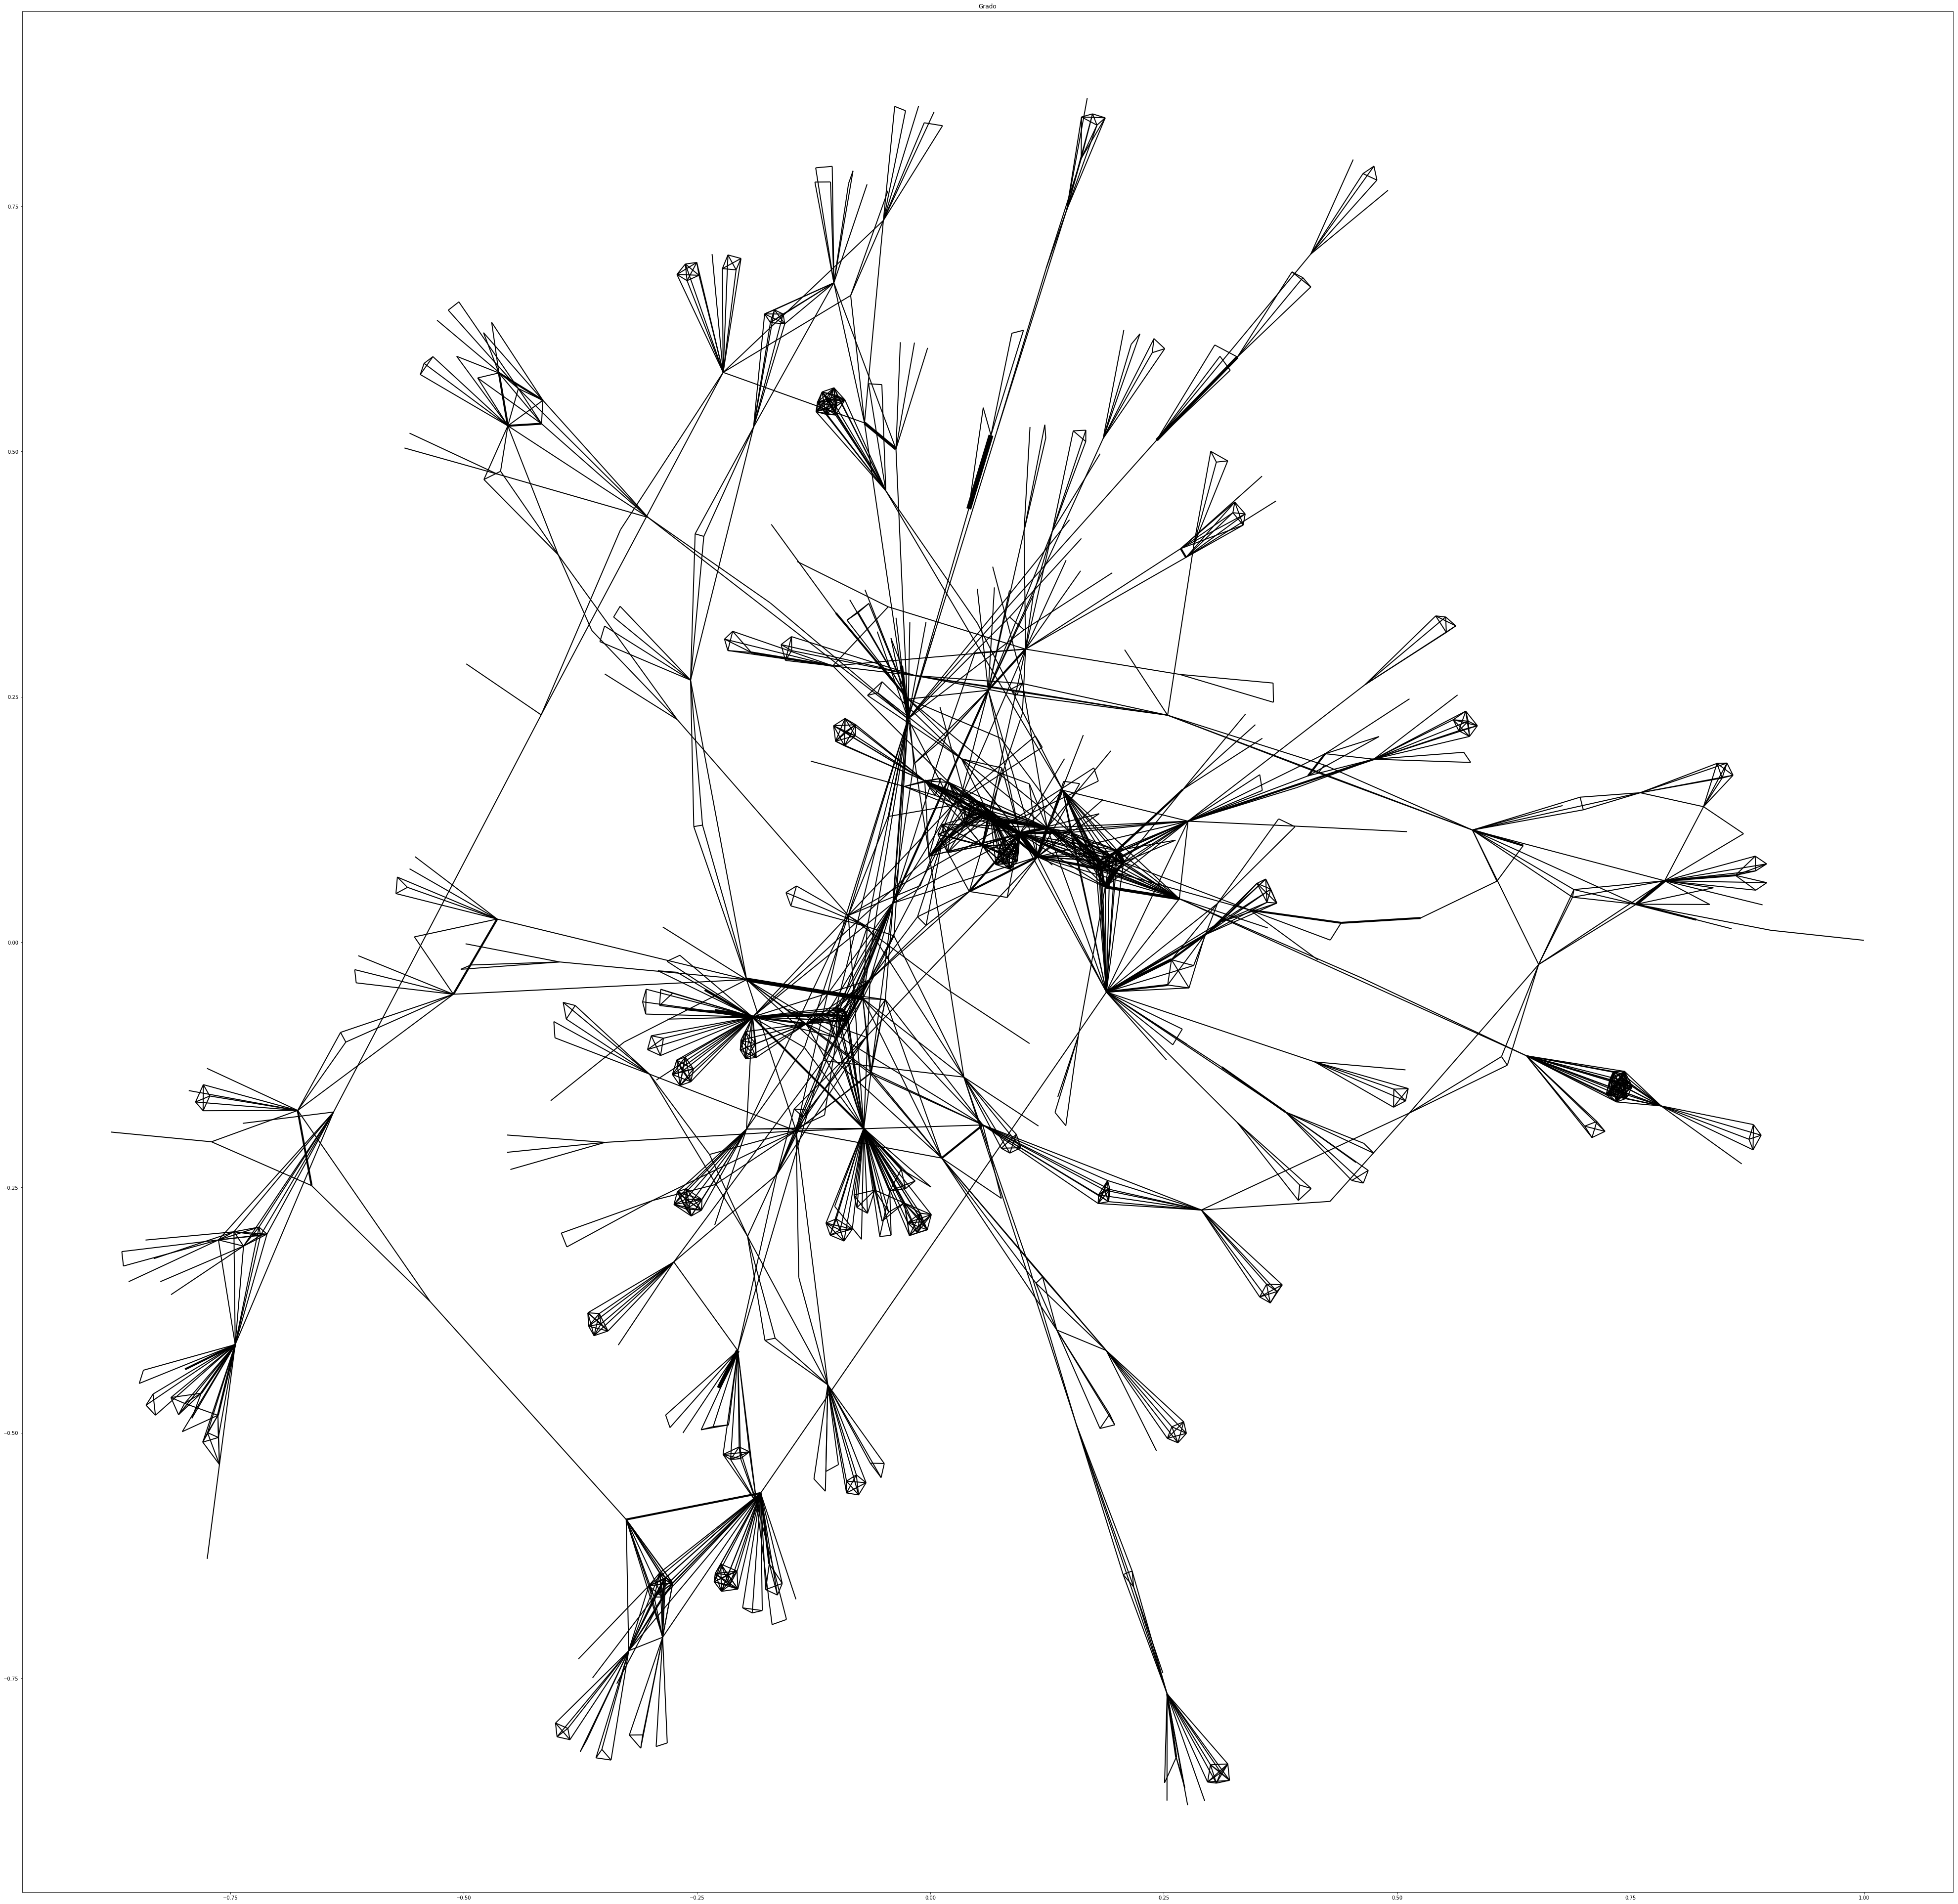

In [19]:
#Busco nodos centrales
#grado PP

centrgradPP = []
for node in PP.nodes:
    centrgradPP.append([node,PP.degree(weight='weight')[node]])
centrgradPP.sort(key=lambda grado: grado[1], reverse=True)
# print(centrgradPP)

plt.figure(figsize=(70,70))
# for name,label in comunidadesPP.items():
#     PP.nodes()[name]["color"] = label

nx.draw_networkx(PP, nodelist=d.keys(), node_size=[v * 7000/max(list(d.values())) for v in d.values()], cmap=plt.get_cmap('plasma'),
                 node_color=list(nx.get_node_attributes(PP, "color").values()),
                 edgelist=list(nx.get_edge_attributes(PP,'weight').keys()), 
                 width=[t * 10/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
#                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
                 with_labels=False)
plt.title('Grado')
# plt.savefig ("Particion_Louvain.png")
plt.show()

In [20]:
#grado BIP
centrgradB = []
for i in range(2):
    if '1' in bipartite.sets(Bmax)[i]:
        for node in bipartite.sets(Bmax)[i]:
            centrgradB.append([node,PP.degree[node]])
centrgradB.sort(key=lambda grado: grado[1], reverse=True)            

In [21]:
#Betweenness
centrbet = []
bet = nx.betweenness_centrality(PP,weight='weight')
for node in PP.nodes:
    centrbet.append([node,bet[node]])
centrbet.sort(key=lambda betw: betw[1], reverse=True)
for i in range(21):
    print(Bmax.nodes[centrbet[i][0]]['nombre'])
# print(centrbet)
# plt.figure(figsize=(50,50))
# # for name,label in comunidadesPP.items():
# #     PP.nodes()[name]["color"] = label
# nx.draw_networkx(PP, nodelist=list(bet.keys()), node_size=[v * 30000 for v in bet.values()], cmap=plt.get_cmap('plasma'),
#                  node_color='red',
#                  edgelist=list(nx.get_edge_attributes(PP,'weight').keys()), 
#                  width=[t * 10/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
# #                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
#                  with_labels=False)
# plt.title('Louvain')
# plt.savefig ("Particion_Louvain.png")
# plt.show()
# print(bet)
# print (centrbet)

['WillisJenny']
['SlatteryMaurice']
['AbramsChad']
['BendixJerryLee']
['SteinerCatherine']
['KingMalcolm']
['GunnersonPaul']
['HemphillBud']
['KatzLuella']
['AndersonMitch']
['KarstenMae']
['BenthamIan']
['WilliamsSherman']
['OneilLinda']
['BartelsAmy']
['AlexanderNolan']
['JamesSara']
['McCannEddie']
['KirklandOwen']
['StevensonMike']
['HenleyThaddeus']


In [22]:
#Betweenness QUITANDO NODOS (FUE UNA PRUEBA PARA VER QUE ONDA)
centrbet2 = []
copiag = copy.deepcopy(PP)
for _ in range(21):
    copiag = max (nx.connected_component_subgraphs(copiag) , key = len)
    bet2 = nx.betweenness_centrality(copiag,weight='weight')
    for i in bet2.keys():
        if bet2[i]==max(list(bet2.values())):
            centrbet2.append(i)
            copiag.remove_nodes_from([i])
#             print(i, bet2[i])
            break
# centrbet2.sort(key=lambda betw: betw[1], reverse=True)
# print(centrbet2)

# Preguntas
* ¿es correcto realizar un desarmado de la red en base a la centralidad de los nodos para definir qué parametro de centralidad es más importante?
* Observar si se puede obtener informacion de un crimen de personas no involucradas directamente en ese crimen (analizando: Comunidades + Alg. Recomendacion)

In [23]:
#Clustering
clus = nx.clustering(PP, weight='weight')
# plt.figure(figsize=(50,50))
# # for name,label in comunidadesPP.items():
# #     PP.nodes()[name]["color"] = label
# nx.draw_networkx(PP, nodelist=list(clus.keys()), node_size=[v * 3000 for v in clus.values()], cmap=plt.get_cmap('plasma'),
#                  node_color='red',
#                  edgelist=list(nx.get_edge_attributes(PP,'weight').keys()), 
#                  width=[t * 10/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
# #                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
#                  with_labels=False)
# plt.title('cLUSTERIG')
# # plt.savefig ("Particion_Louvain.png")
# plt.show()

## Asortatividad
##### Version de Juan en listas

In [24]:
#ASORTATIVIDAD
N_sos = [] #1er elemento, número de crimenes en los que la persona 1 fue sospechoso.
N_test = [] #1er elemento, número de crimenes en los que la persona 1 fue testigo.
N_vict = [] #1er elemento, número de crimenes en los que la persona 1 fue victima.
N_dual = []

NS = 0
NT = 0
NV = 0
ND = 0

for i in range (1,len (data_total)):
    if data_total [i][0] == data_total [i-1][0]:
        if ["Suspect"] == roles [i-1]:
            NS = NS + 1
        elif  ['Witness'] == roles [i-1]:
            NT = NT + 1
        elif ['Victim'] == roles [i-1]:
            NV = NV + 1
        elif ['Victim', 'Suspect'] == roles [i-1]:
            ND = ND + 1

    elif data_total [i][0] != data_total [i-1][0]:

        if ["Suspect"] == roles [i-1]:
            NS = NS + 1
        elif  ['Witness'] == roles [i-1]:
            NT = NT + 1
        elif ['Victim'] == roles [i-1]:
            NV = NV + 1
        elif ['Victim', 'Suspect'] == roles [i-1]:
            ND = ND + 1
        N_sos.append(NS)
        N_test.append(NT)
        N_vict.append(NV)
        N_dual.append(ND)
        NS = 0
        NT = 0
        NV = 0
        ND = 0
        
    try:
        assert (i < (len (data_total)-1))
    except AssertionError:
        if ["Suspect"] == roles [i]:
            NS = NS + 1
        elif  ['Witness'] == roles [i]:
            NT = NT + 1
        elif ['Victim'] == roles [i]:
            NV = NV + 1
        elif ['Victim', 'Suspect'] == roles [i]:
            ND = ND + 1
        N_sos.append(NS)
        N_test.append(NT)
        N_vict.append(NV)
        N_dual.append(ND)

##### Version diccionarios

In [25]:
#Diccionarios con numero de enlaces sospechosos, victimas, testigos y duales
Nsos={}
Nvic={}
Ntest={}
Ndual={}
for node in bipartite.sets(Bmax)[0]:
    v=0
    s=0
    d=0
    t=0
    for edge in Bmax.edges(node):
        if Bmax.edges[edge]['rol']==['Victim']:
            v=v+1
        if Bmax.edges[edge]['rol']==['Suspect']:
            s=s+1
        if Bmax.edges[edge]['rol']==['Witness']:
            t=t+1
        if Bmax.edges[edge]['rol']==['Victim', 'Suspect']:
            d=d+1
    Nsos[node] = s
    Nvic[node] = v
    Ntest[node] = t
    Ndual[node] = d
# print (Nsos)
# print(Nvic)
# print(Ntest)

##### Plotear grado de 'atributo' en funcion del grado medio del mismo atributo en los vecinos

In [26]:
diccionariosN = [Nsos,Nvic,Ntest,Ndual]

def asortatividad(g,dic):
    xnod = []
    xvec = []
    tot = []
    for node in g.nodes:
        xnod.append(dic[node])
        k = 0
        n = 0
        for vecino in g.neighbors(node): #sumo los grados de los vecinos
            k = k + dic[vecino]
            n = n + 1
        xvec.append(k/n)
        tot.append([dic[node],k/n])
    grados = list(set(xnod))
    xprom = []
    for k in grados:
        p = 0
        n = 0
        for i in tot:
            if i[0]==k:
                p = p + i[1]
                n = n + 1
        xprom.append(p/n)    
    
    plt.plot(xnod,xvec,'*')
#     plt.show()
        
    plt.plot(grados,xprom,'r*')
#     plt.yscale('log')
#     plt.xscale('log')
    plt.show
    
    

##### Funcion que calcula la asortatividad

In [27]:
#Asortatividad
def coef_asort(g, dic):
    
    S1 = 0
    S2 = 0
    Se = 0 
    S3 = 0
    
    for node in g.nodes():

        S1 = S1 + dic[node]
        S2 = S2 + dic[node]**2
        S3 = S3 + dic[node]**3
        
        for vecino in g.neighbors(node):
            Se = Se + dic[node]*dic[vecino]
        
    r = (S1*Se-S2**2)/(S1*S3-S2**2) #ASORTATIVIDAD
    
    return r 

In [28]:
rsos = coef_asort(PP,diccionariosN[0])
rvic = coef_asort(PP,diccionariosN[1])
print(rsos,rvic)

0.11142646012548753 0.7814579851566217


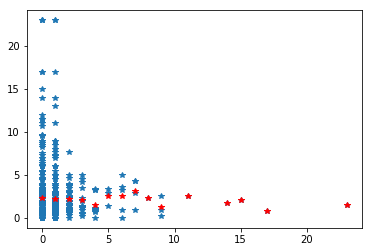

In [29]:
asortatividad(PP,diccionariosN[0])
plt.savefig('Asort-sos.png')

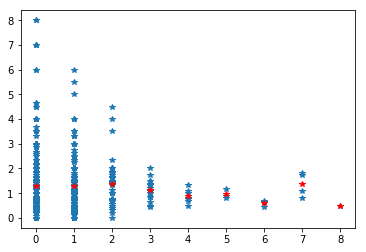

In [30]:
asortatividad(PP,diccionariosN[1])
plt.savefig('Asort-vic.png')

### ----------------------------------------------------------------------------------------

## Desarmado de la red

In [40]:
def impacto_random (g,n):
    for _ in range(n):
        gg = copy.deepcopy(g)
        x = []
        todo=[]
        y = []
        #Tomo la componente gigante de mi grafo. Como criterio se toma el largo (key = len) y tomo el subgrafo con el máximo.
        comp_gig = max (nx.connected_component_subgraphs(gg) , key = len)
        N = int (comp_gig.number_of_nodes())
        i = 0
        while len (comp_gig) > 40: #Modificando el numero podemos determinar hasta cuando va a analizar el largo de la red.
            nodos = [] #Nodos de la componente gigante.
            grados = [] #Grado de ellos.
            for node in  comp_gig.nodes:
                nodos.append (node)
                grados.append (comp_gig.degree(node))
            nodo = random.choice(nodos) #elijo nodo aleatoriamente
            comp_gig.remove_nodes_from([nodo])
            i = i + 1
            x.append (i/float (N))
            comp_gig = max (nx.connected_component_subgraphs(comp_gig) , key = len)
            y.append(len(comp_gig)/float (N)) #IMPORTANTE:El numerador es el largo NUEVO de la componente gigante y#el denominador te da el largo antes de la extracción del nodo central.
   
        todo.append([x,y])
        
    xx=[]
    yy=[]
    xxx=0
    yyy=0
    for i in todo:
        xxx=0
        yyy=0
        for j in range(len(i[0])):
            xxx=i[0][j]/len(todo)+xxx
            yyy=i[1][j]/len(todo)+yyy
        xx.append(xxx)
        yy.append(yyy)
            
            
    return [x,y]

In [32]:
def impacto_parametro (g,param,n):
    gg = copy.deepcopy(g)
    x = []
    todo=[]
    y = []
    #Tomo la componente gigante de mi grafo. Como criterio se toma el largo (key = len) y tomo el subgrafo con el máximo.
    comp_gig = max (nx.connected_component_subgraphs(gg) , key = len)
    N = int (comp_gig.number_of_nodes())
    i = 0
    
    for i in range(n):
        comp_gig.remove_nodes_from([param[i][0]])
        i = i + 1
        x.append (i/float (N))
        comp_gig = max (nx.connected_component_subgraphs(comp_gig) , key = len)
        y.append(len(comp_gig)/float (N)) #IMPORTANTE:El numerador es el largo NUEVO de la componente gigante y#el denominador te da el largo antes de la extracción del nodo central.

    todo.append([x,y])
            
    return [x,y]

[['425', 65],
 ['2', 55],
 ['356', 49],
 ['695', 39],
 ['56', 37],
 ['715', 37],
 ['497', 36],
 ['10', 30],
 ['815', 29],
 ['404', 27],
 ['74', 26],
 ['531', 25],
 ['533', 25],
 ['54', 24],
 ['413', 24],
 ['572', 24],
 ['128', 23],
 ['396', 22],
 ['811', 21],
 ['343', 20],
 ['397', 20],
 ['439', 20],
 ['37', 19],
 ['73', 19],
 ['97', 19],
 ['114', 19],
 ['219', 19],
 ['361', 19],
 ['659', 19],
 ['774', 19],
 ['776', 19],
 ['514', 18],
 ['549', 18],
 ['59', 17],
 ['220', 17],
 ['729', 17],
 ['736', 17],
 ['743', 17],
 ['775', 17],
 ['777', 17],
 ['778', 17],
 ['82', 16],
 ['336', 16],
 ['563', 16],
 ['812', 16],
 ['17', 15],
 ['62', 15],
 ['88', 15],
 ['384', 15],
 ['681', 15],
 ['51', 14],
 ['98', 14],
 ['106', 14],
 ['149', 14],
 ['304', 14],
 ['305', 14],
 ['365', 14],
 ['408', 14],
 ['473', 14],
 ['477', 14],
 ['484', 14],
 ['487', 14],
 ['562', 14],
 ['698', 14],
 ['699', 14],
 ['719', 14],
 ['726', 14],
 ['748', 14],
 ['816', 14],
 ['57', 13],
 ['115', 13],
 ['214', 13],
 ['225', 

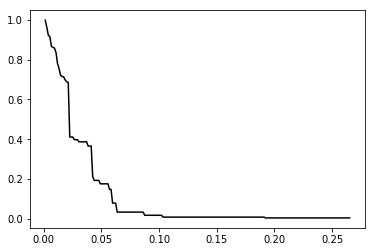

In [33]:
grado = impacto_parametro(PP,centrgradPP,200)
plt.plot(grado[0],grado[1],'k')
centrgradPP

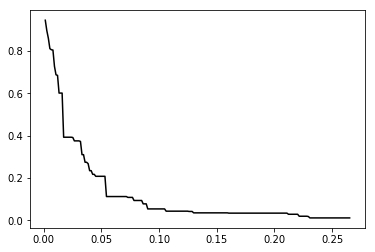

In [34]:
bett = impacto_parametro(PP,centrbet,200)
plt.plot(bett[0],bett[1],'k')

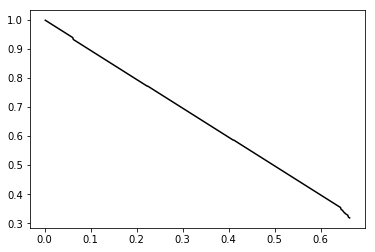

In [43]:
cluss = impacto_parametro(PP,centrclus,500)
plt.plot(cluss[0],cluss[1],'k')

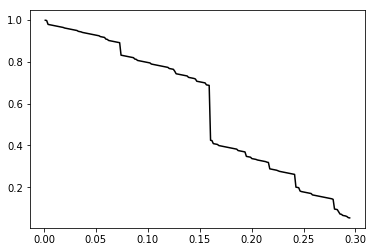

In [41]:
randomm = impacto_random (PP,10)
plt.plot(randomm[0],randomm[1],'k')

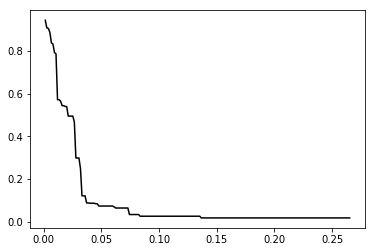

In [38]:
gradBB = impacto_parametro(PP,centrgradBmax,200)
plt.plot(gradBB[0],gradBB[1],'k')

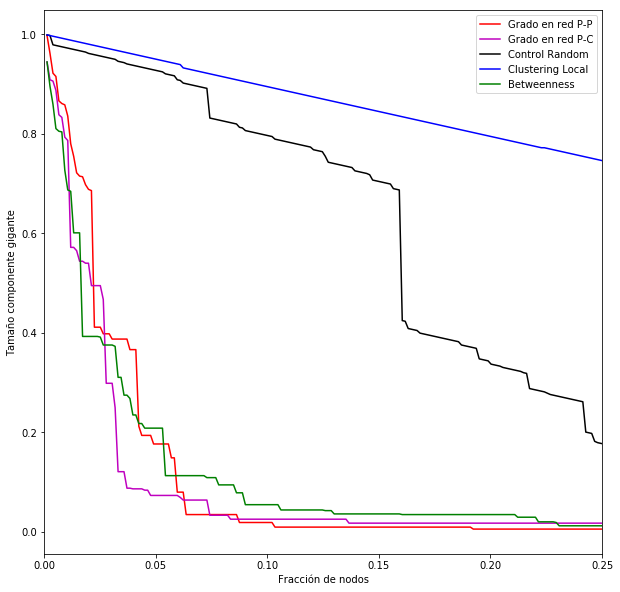

In [44]:
plt.figure(figsize=(10,10))
plt.plot(grado[0],grado[1],'r',label='Grado en red P-P')
plt.plot(gradBB[0],gradBB[1],'m',label='Grado en red P-C')
plt.plot(randomm[0],randomm[1],'k',label='Control Random')
plt.plot(cluss[0],cluss[1],'b',label='Clustering Local')
plt.plot(bett[0],bett[1],'g',label='Betweenness')
plt.xlim(0,0.25)
plt.xlabel('Fracción de nodos')
plt.ylabel('Tamaño componente gigante')
plt.legend()
# plt.savefig('Desarmado.png')

plt.show()

In [37]:
centrclus = []
for nodes in list(clus.keys()):
    centrclus.append([nodes,clus[nodes]])
centrclus.sort(key=lambda clu: clu[1], reverse=True)
centrclus

[['143', 0.34199518933533946],
 ['67', 0.31748021039363994],
 ['90', 0.31748021039363994],
 ['342', 0.31748021039363994],
 ['316', 0.2884499140614817],
 ['348', 0.2884499140614817],
 ['395', 0.2884499140614817],
 ['663', 0.2884499140614817],
 ['703', 0.2884499140614817],
 ['28', 0.28198786976442963],
 ['412', 0.2641454581530029],
 ['23', 0.2519842099789747],
 ['89', 0.2519842099789747],
 ['102', 0.2519842099789747],
 ['151', 0.2519842099789747],
 ['169', 0.2519842099789747],
 ['197', 0.2519842099789747],
 ['204', 0.2519842099789747],
 ['284', 0.2519842099789747],
 ['288', 0.2519842099789747],
 ['403', 0.2519842099789747],
 ['550', 0.2519842099789747],
 ['667', 0.2519842099789747],
 ['727', 0.2519842099789747],
 ['745', 0.2519842099789747],
 ['792', 0.2519842099789747],
 ['787', 0.24073375733306765],
 ['147', 0.23916007013121332],
 ['805', 0.23465613998598314],
 ['641', 0.2294833046871606],
 ['86', 0.22948330468716058],
 ['398', 0.22599210498948732],
 ['568', 0.22599210498948732],
 ['9'

In [36]:
centrgradBmax=[]
for node in bipartite.sets(Bmax)[0]:
    centrgradBmax.append([node,Bmax.degree(node)])
centrgradBmax.sort(key=lambda clu: clu[1], reverse=True)
centrgradBmax

[['815', 25],
 ['2', 22],
 ['425', 18],
 ['220', 17],
 ['56', 14],
 ['715', 12],
 ['356', 11],
 ['695', 11],
 ['514', 11],
 ['404', 10],
 ['531', 10],
 ['659', 9],
 ['592', 9],
 ['497', 9],
 ['115', 9],
 ['336', 9],
 ['474', 9],
 ['696', 9],
 ['10', 8],
 ['729', 8],
 ['88', 8],
 ['37', 8],
 ['291', 7],
 ['690', 7],
 ['214', 7],
 ['277', 7],
 ['797', 7],
 ['74', 7],
 ['159', 7],
 ['572', 7],
 ['414', 7],
 ['549', 7],
 ['62', 6],
 ['533', 6],
 ['767', 6],
 ['128', 6],
 ['413', 6],
 ['384', 6],
 ['51', 6],
 ['190', 6],
 ['108', 6],
 ['79', 6],
 ['736', 6],
 ['642', 5],
 ['536', 5],
 ['811', 5],
 ['502', 5],
 ['344', 5],
 ['17', 5],
 ['242', 5],
 ['681', 5],
 ['577', 5],
 ['155', 5],
 ['129', 5],
 ['788', 5],
 ['396', 5],
 ['515', 4],
 ['410', 4],
 ['112', 4],
 ['67', 4],
 ['812', 4],
 ['304', 4],
 ['397', 4],
 ['343', 4],
 ['763', 4],
 ['1', 4],
 ['333', 4],
 ['345', 4],
 ['87', 4],
 ['600', 4],
 ['54', 4],
 ['405', 4],
 ['680', 4],
 ['131', 4],
 ['221', 4],
 ['174', 4],
 ['362', 3],
 ['3

# ATRIBUTOS

In [45]:
for node in PP.nodes:
    PP.nodes[node]['gradoPC']=Bmax.degree(node)
    PP.nodes[node]['gradoPP']=PP.degree(node,weight='weight')
    PP.nodes[node]['Betweenness']=bet[node]
    PP.nodes[node]['Clustering']=clus[node]

In [46]:
# nx.write_gexf(PP,'PP.gexf')
# nx.write_gexf(B,'Bipartita.gexf')

558 271


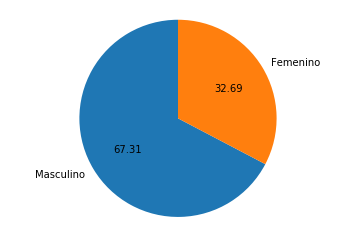

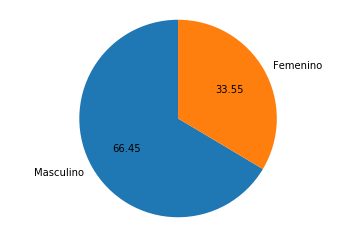

In [51]:
# The slice names of a population distribution pie chart
pieLabels = ['Masculino','Femenino']
 
# Population data
m=0
f=0
for i in sexos:
    if i==['1']:
        m=m+1
    else:
        f=f+1
print(m, f)      
porcentajes = [m,f]

figureObject, axesObject = plt.subplots()
 
# Draw the pie chart
# plt.figure(figsize=(15,15))
axesObject.pie(porcentajes, 
        labels=pieLabels, 
        autopct='%1.2f',
        startangle=90)
 
# Aspect ratio - equal means pie is a circle
axesObject.axis('equal')
plt.savefig('sexosB.png')
plt.show()

m=0
f=0
for node in PP.nodes:
    if PP.nodes[node]['sexo']==['1']:
        m=m+1
    else:
        f=f+1
porcentajes = [m,f]

figureObject, axesObject = plt.subplots()
 
# Draw the pie chart
# plt.figure(figsize=(15,15))
axesObject.pie(porcentajes, 
        labels=pieLabels, 
        autopct='%1.2f',
        startangle=90)
 
# Aspect ratio - equal means pie is a circle
axesObject.axis('equal')
plt.savefig('sexosPP.png')
plt.show()


In [52]:
rankings=[centrbet,centrclus,centrgradBmax,centrgradPP,centrbet2]
lista_rank=[]
for i in range(len(rankings)):
    lista_rank.append([])
    for j in range(20):
        lista_rank[i].append(PP.nodes[rankings[i][j][0]]['nombre'][0])
# print(lista_rank)

overlap=[]
for i in range(len(lista_rank)-1):
    overlap.append([])
    for j in range(i+1,len(rankings)):
        overlap[i].append([])
        for elem in lista_rank[i]:
            if elem in lista_rank[j]:
                overlap[i][j-i-1].append(elem)
print(overlap)

# porcentajes=[]

# tabla_red = pd.DataFrame ({"Redes":["AP_MS","LIT","Y2H"],
#                              "Num_Nodos":[num_nod("yeast_AP-MS.txt"),num_nod("yeast_LIT.txt"),num_nod("yeast_Y2H.txt")],
#                              "Num_Enlaces":[num_edges("yeast_AP-MS.txt"),num_edges("yeast_LIT.txt"),num_edges("yeast_Y2H.txt")],
#                              "No-Dirigida":[dirigida("yeast_AP-MS.txt") == 0,dirigida("yeast_LIT.txt") == 0,dirigida("yeast_Y2H.txt") == 0],
#                              "Grado Medio / [Kin,Kout]":[grado("yeast_AP-MS.txt"),grado("yeast_LIT.txt"),grado("yeast_Y2H.txt")],
#                              "Densidad_Red":[densidad("yeast_AP-MS.txt"),densidad("yeast_LIT.txt"),densidad("yeast_Y2H.txt")],
#                             "Coef_de_Clus":[0,0,0],
#                           })
# print (tabla_red)

10/15*100

[[[], ['WillisJenny', 'AbramsChad', 'BendixJerryLee', 'SteinerCatherine', 'HemphillBud', 'KatzLuella', 'AlexanderNolan', 'McCannEddie'], ['WillisJenny', 'AbramsChad', 'BendixJerryLee', 'SteinerCatherine', 'HemphillBud', 'KatzLuella', 'AlexanderNolan'], ['AbramsChad']], [[], [], []], [['WillisJenny', 'AbramsChad', 'KatzLuella', 'BendixJerryLee', 'SteinerCatherine', 'HemphillBud', 'SmithMichaelThomas', 'JeffersonArnold', 'MitchellGrant', 'MarcusBradley', 'AlexanderNolan'], ['AbramsChad']], [['AbramsChad']]]


66.66666666666666

In [55]:
# print (type(int(centrbet[0][0])))
# print (rol_mayoritario)
bet_rol = []
for i in range (20):
    persona = int (centrbet[i][0])
    bet_rol.append(rol_mayoritario[persona-1])          

IndexError: list index out of range

# Objetivo 1:

In [54]:
rol_mayoritario = []
#Primer estimador permite ver aquellas personas que tuvieron un porcentaje de algún rol mayor al 50%
#Segundo estimador permite ver aquellas personas que no habiendo superado el 50% en ningún rol sin embargo estan por encima
#de otro valor. Alterando este segundo estimador podes observar el porcentaje de los otros roles.
# Para este ultimo comentario probar estimador2 = 0.49 y ver la persona 89, luego probar estimador2 = 0.30 y ver la misma
#persona.
estimador1 = 0.70
estimador2 = 0.30
for l in range (len(N_sos)):
    crim_tot = N_sos[l] + N_test[l] + N_vict [l]
    prop = [[N_sos[l]/crim_tot,'s'],[N_test[l]/crim_tot,'t'],[N_vict[l]/crim_tot,'v']]
    if any (i[0] > estimador1 for i in prop) is True:
        for k in prop:
            if k[0] > estimador1:
                rol_mayoritario.append([l+1,[k[0],k[1]]])
    else:
        pers_rol = []
        for r in prop:
            if r[0] > estimador2:
                pers_rol.append (r)
        rol_mayoritario.append([l+1,pers_rol])
rol_mayoritario

ZeroDivisionError: division by zero

# Objetivo 3:
## Encontrar los enlaces mas pesados, ver si corresponden a sospechosos y ver como afectan a la red

In [56]:
ejes = []
pesos = []
for edge in PP.edges():
    ejes.append([edge,PP.edges[edge]['weight']])
    pesos.append(PP.edges[edge]['weight'])
ejes.sort(key=lambda p: p[1], reverse=True)
pesos.sort(reverse=True)

peso_persona_sos = []
peso_persona_sos.append(['Peso,Pers, S,V,D,  Sex,     Pers,   S, V, D,   Sex'])
for i in ejes:
    peso_persona_sos.append([i[1],i[0][0],[Nsos[i[0][0]],Nvic[i[0][0]],Ndual[i[0][0]],[Bmax.nodes[i[0][0]]['sexo']]],i[0][1],[Nsos[i[0][1]],Nvic[i[0][1]],Ndual[i[0][1]],[Bmax.nodes[i[0][1]]['sexo']]]])
peso_persona_sos


[['Peso,Pers, S,V,D,  Sex,     Pers,   S, V, D,   Sex'],
 [5, '79', [0, 6, 0, [['0']]], '767', [6, 0, 0, [['1']]]],
 [5, '128', [0, 5, 0, [['0']]], '531', [5, 3, 1, [['1']]]],
 [5, '425', [15, 2, 0, [['0']]], '715', [11, 0, 0, [['0']]]],
 [4, '2', [17, 4, 0, [['1']]], '67', [0, 3, 0, [['0']]]],
 [4, '17', [5, 0, 0, [['1']]], '514', [3, 7, 0, [['1']]]],
 [4, '87', [4, 0, 0, [['1']]], '659', [0, 8, 0, [['1']]]],
 [4, '413', [6, 0, 0, [['1']]], '425', [15, 2, 0, [['0']]]],
 [4, '533', [4, 1, 1, [['1']]], '572', [2, 4, 0, [['1']]]],
 [3, '37', [6, 1, 0, [['1']]], '797', [5, 2, 0, [['1']]]],
 [3, '54', [2, 1, 0, [['1']]], '425', [15, 2, 0, [['0']]]],
 [3, '56', [3, 7, 2, [['1']]], '303', [0, 2, 0, [['0']]]],
 [3, '333', [1, 1, 0, [['1']]], '592', [7, 2, 0, [['0']]]],
 [3, '344', [1, 4, 0, [['1']]], '696', [7, 2, 0, [['0']]]],
 [3, '396', [4, 0, 0, [['0']]], '531', [5, 3, 1, [['1']]]],
 [3, '413', [6, 0, 0, [['1']]], '695', [9, 1, 0, [['1']]]],
 [3, '425', [15, 2, 0, [['0']]], '695', [9, 1, 

In [57]:
persona_sos_vic=[]
for element in peso_persona_sos:
    if len(element)>1:
        if element[0]>2:
            v1=0
            v2=0
            s1=0
            s2=0
            for crimen in nx.common_neighbors(Bmax,element[1],element[3]):
#                 print((crimen,element[1]))
                if Bmax.edges[(crimen,element[1])]['rol']==['Suspect']:
                    s1=s1+1
                if Bmax.edges[(crimen,element[1])]['rol']==['Victim','Suspect']:
                    s1=s1+1
                if Bmax.edges[(crimen,element[3])]['rol']==['Suspect']:
                    s2=s2+1
                if Bmax.edges[(crimen,element[1])]['rol']==['Victim','Suspect']:
                    s2=s2+1
                if Bmax.edges[(crimen,element[1])]['rol']==['Victim']:
                    v1=v1+1
                if Bmax.edges[(crimen,element[3])]['rol']==['Victim']:
                    v2=v2+1
            persona_sos_vic.append([element[0],[element[1],s1,v1,comunidadesPP[element[1]]],[element[3],s2,v2,comunidadesPP[element[3]]]])
persona_sos_vic

[[5, ['79', 0, 5, 17], ['767', 5, 0, 17]],
 [5, ['128', 0, 4, 3], ['531', 4, 0, 3]],
 [5, ['425', 4, 0, 3], ['715', 4, 0, 3]],
 [4, ['2', 4, 0, 1], ['67', 0, 3, 1]],
 [4, ['17', 4, 0, 0], ['514', 0, 3, 0]],
 [4, ['87', 4, 0, 15], ['659', 0, 4, 15]],
 [4, ['413', 4, 0, 3], ['425', 4, 0, 3]],
 [4, ['533', 3, 1, 3], ['572', 1, 2, 3]],
 [3, ['37', 2, 0, 7], ['797', 2, 1, 7]],
 [3, ['54', 2, 0, 3], ['425', 3, 0, 3]],
 [3, ['56', 0, 2, 8], ['303', 0, 2, 8]],
 [3, ['333', 0, 1, 13], ['592', 1, 2, 13]],
 [3, ['344', 0, 3, 22], ['696', 3, 0, 22]],
 [3, ['396', 2, 0, 3], ['531', 0, 2, 3]],
 [3, ['413', 3, 0, 3], ['695', 3, 0, 3]],
 [3, ['425', 2, 0, 3], ['695', 2, 0, 3]],
 [3, ['663', 0, 2, 10], ['815', 3, 0, 10]],
 [3, ['695', 2, 0, 3], ['715', 2, 0, 3]]]

In [58]:
comunidadesPP['1']

0

In [59]:
for i in persona_sos_vic:
    if i[1][1]>i[0]/2 and i[2][1]>i[0]/2:
        i.append('Grupo Sospechoso')
    if (i[1][1]>i[0]/2 and i[2][2]>i[0]/2) or (i[1][2]>i[0]/2 and i[2][1]>i[0]/2):
        i.append('Persona atacada')
    if i[1][2]>i[0]/2 and i[2][2]>i[0]/2:
        i.append('Grupo de Victimas')
persona_sos_vic

[[5, ['79', 0, 5, 17], ['767', 5, 0, 17], 'Persona atacada'],
 [5, ['128', 0, 4, 3], ['531', 4, 0, 3], 'Persona atacada'],
 [5, ['425', 4, 0, 3], ['715', 4, 0, 3], 'Grupo Sospechoso'],
 [4, ['2', 4, 0, 1], ['67', 0, 3, 1], 'Persona atacada'],
 [4, ['17', 4, 0, 0], ['514', 0, 3, 0], 'Persona atacada'],
 [4, ['87', 4, 0, 15], ['659', 0, 4, 15], 'Persona atacada'],
 [4, ['413', 4, 0, 3], ['425', 4, 0, 3], 'Grupo Sospechoso'],
 [4, ['533', 3, 1, 3], ['572', 1, 2, 3]],
 [3, ['37', 2, 0, 7], ['797', 2, 1, 7], 'Grupo Sospechoso'],
 [3, ['54', 2, 0, 3], ['425', 3, 0, 3], 'Grupo Sospechoso'],
 [3, ['56', 0, 2, 8], ['303', 0, 2, 8], 'Grupo de Victimas'],
 [3, ['333', 0, 1, 13], ['592', 1, 2, 13]],
 [3, ['344', 0, 3, 22], ['696', 3, 0, 22], 'Persona atacada'],
 [3, ['396', 2, 0, 3], ['531', 0, 2, 3], 'Persona atacada'],
 [3, ['413', 3, 0, 3], ['695', 3, 0, 3], 'Grupo Sospechoso'],
 [3, ['425', 2, 0, 3], ['695', 2, 0, 3], 'Grupo Sospechoso'],
 [3, ['663', 0, 2, 10], ['815', 3, 0, 10], 'Persona ata

In [60]:
for edge in PP.edges():
    PP.edges[edge]['Color']='Black'
    
for element in persona_sos_vic:
    if len(element)>3:
        if element[3]=='Persona atacada':
            PP.edges[(element[1][0],element[2][0])]['Color']='Blue'
        if element[3]=='Grupo Sospechoso':
            PP.edges[(element[1][0],element[2][0])]['Color']='Red'
        if element[3]=='Grupo de Victimas':
            PP.edges[(element[1][0],element[2][0])]['Color']='Green'
            

In [61]:
listaejes=[]
colorejes=[]
for edge in PP.edges():
    if PP.edges[edge]['Color'] != 'Black':
        listaejes.append(edge)
        colorejes.append(PP.edges[edge]['Color'])
listaejes
colorejes

['Blue',
 'Blue',
 'Red',
 'Red',
 'Green',
 'Blue',
 'Blue',
 'Blue',
 'Blue',
 'Blue',
 'Red',
 'Red',
 'Red',
 'Red',
 'Blue',
 'Red']

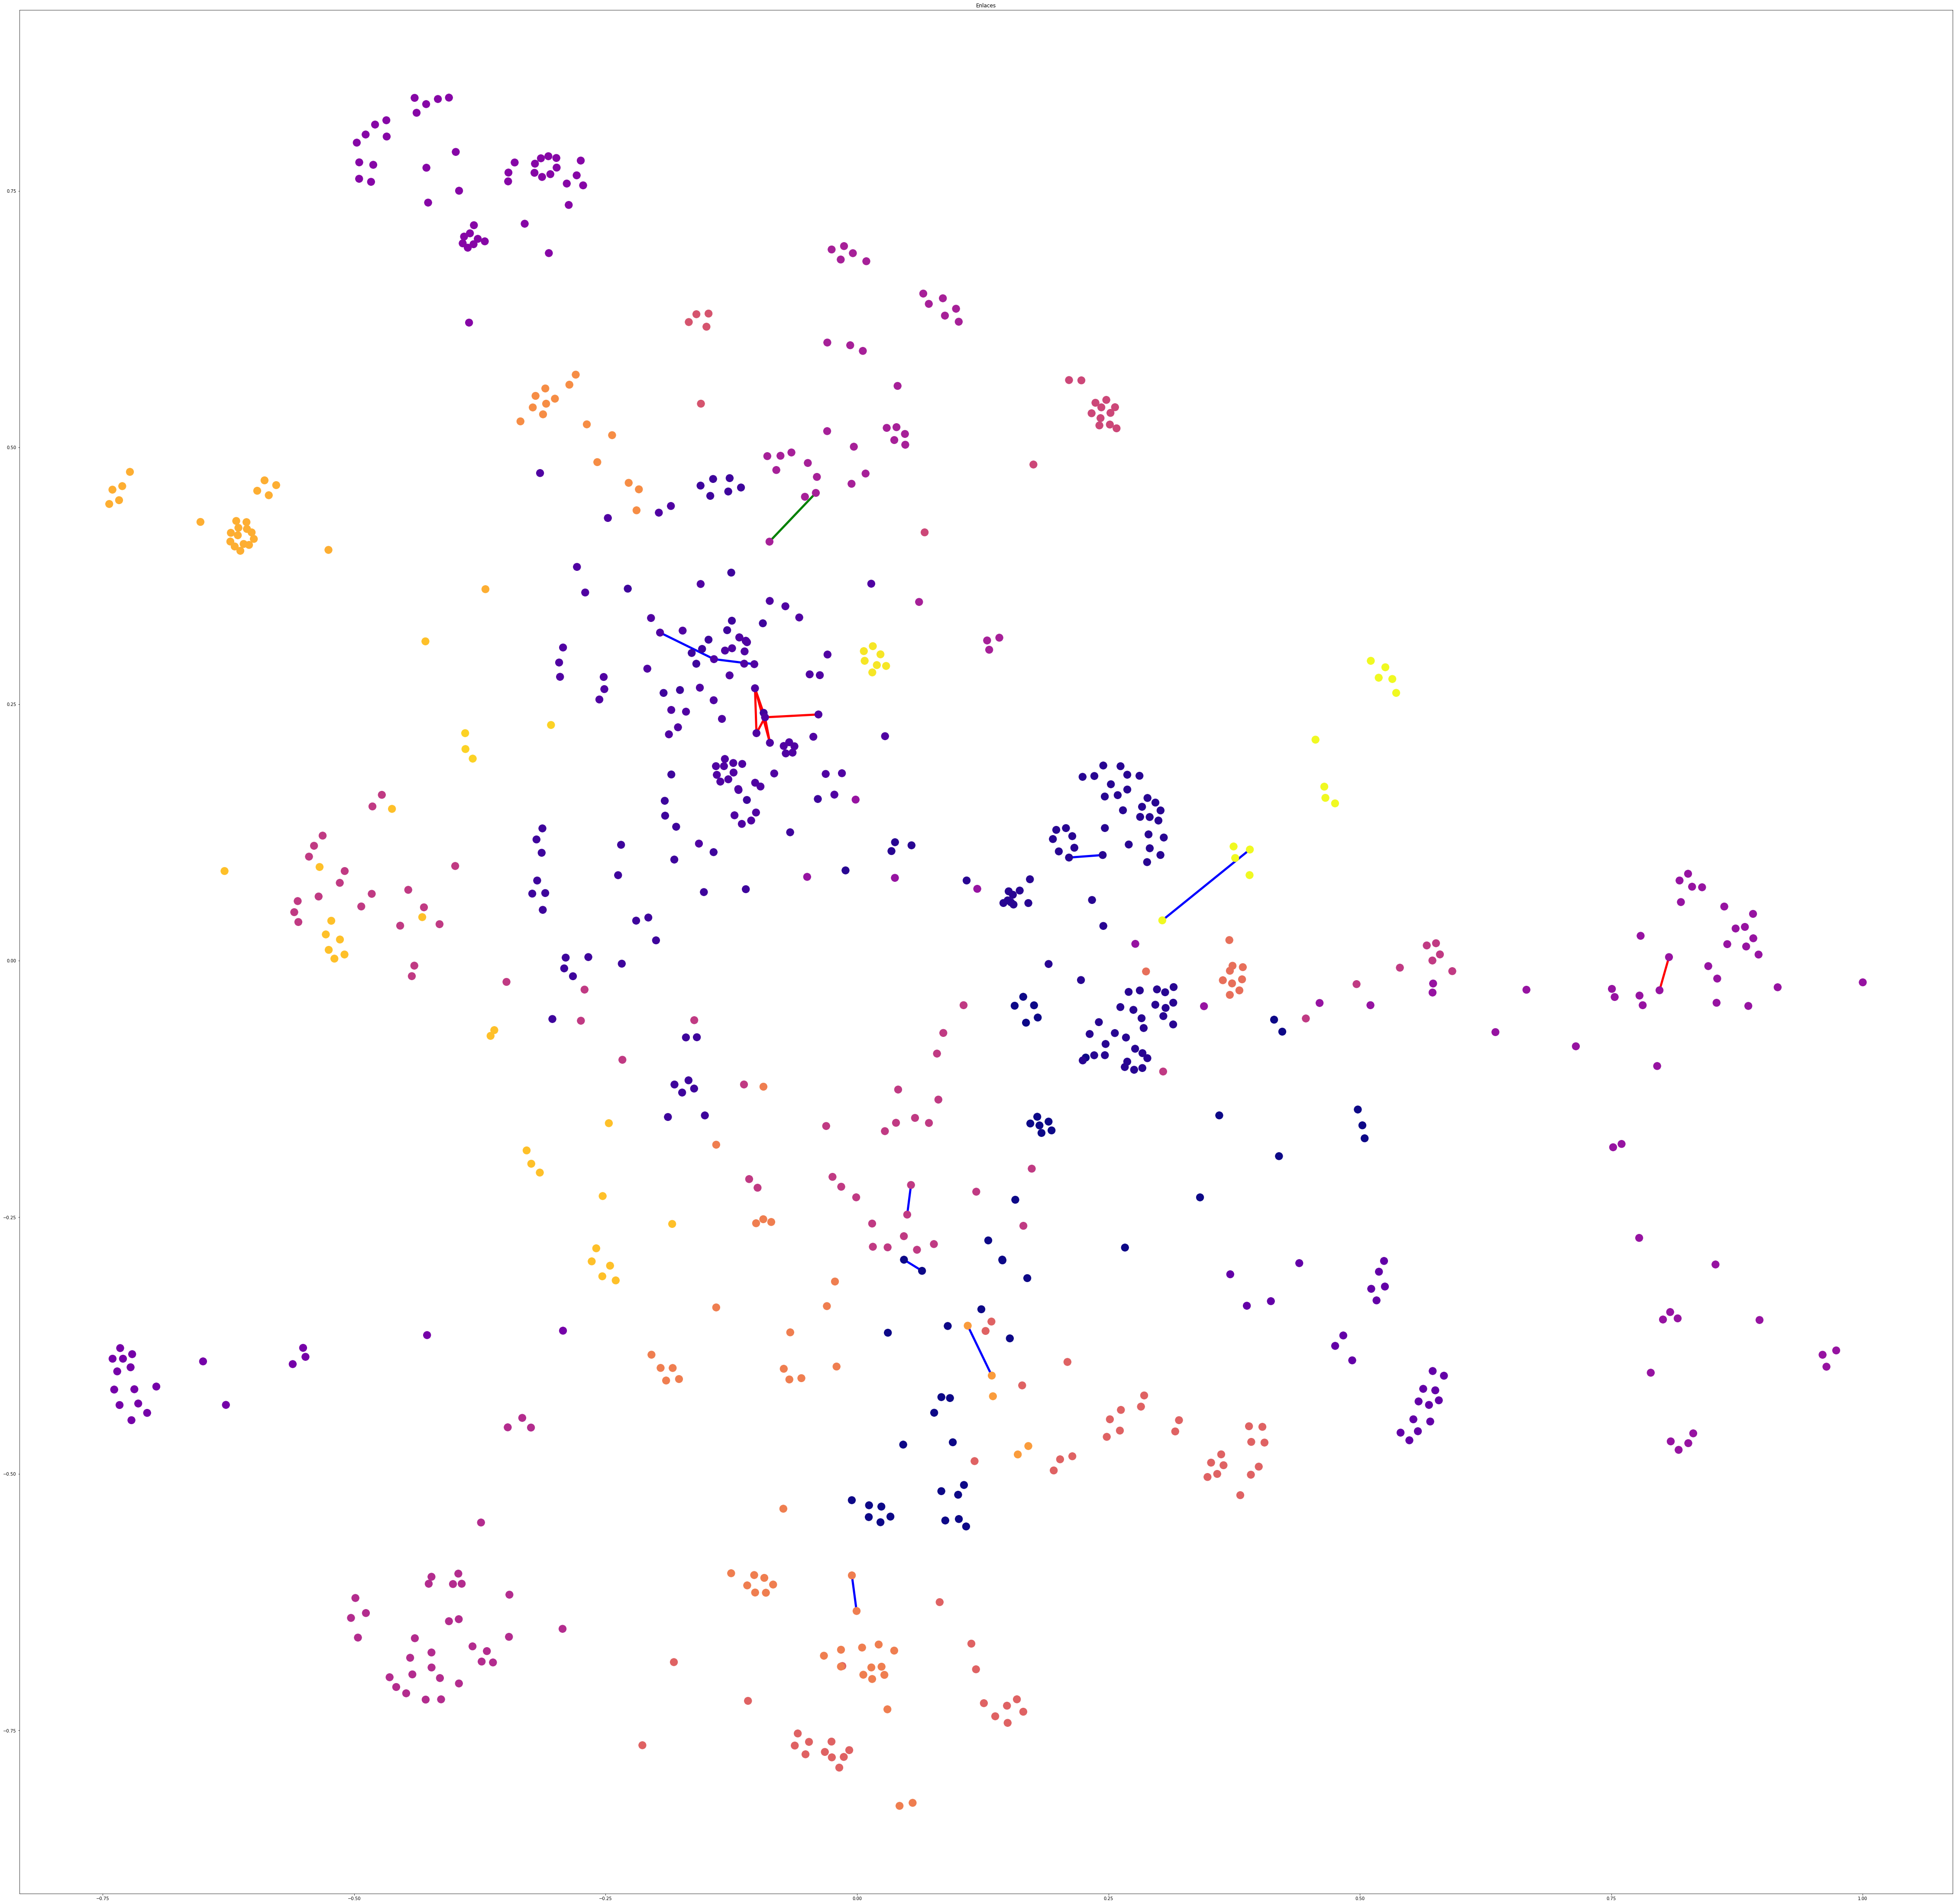

In [62]:
plt.figure(figsize=(80,80))
for name,label in comunidadesPP.items():
    PP.nodes()[name]["color"] = label

nx.draw_networkx(PP, nodelist=list(bet.keys()), 
#                  node_size=[v * 30000 for v in bet.values()],
                 cmap=plt.get_cmap('plasma'),
                 node_color=list(nx.get_node_attributes(PP,'color').values()),
#                  edgelist=list(nx.get_edge_attributes(PP,'Color').keys()),
                 edgelist=listaejes,
#                  edge_color=list(nx.get_edge_attributes(PP,'Color').values()),
                 edge_color=colorejes,
#                  width=[t * 10/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
#                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
                 width=5,
                 with_labels=False)
plt.title('Enlaces')
# plt.savefig ("Particion_Louvain.png")
plt.show()

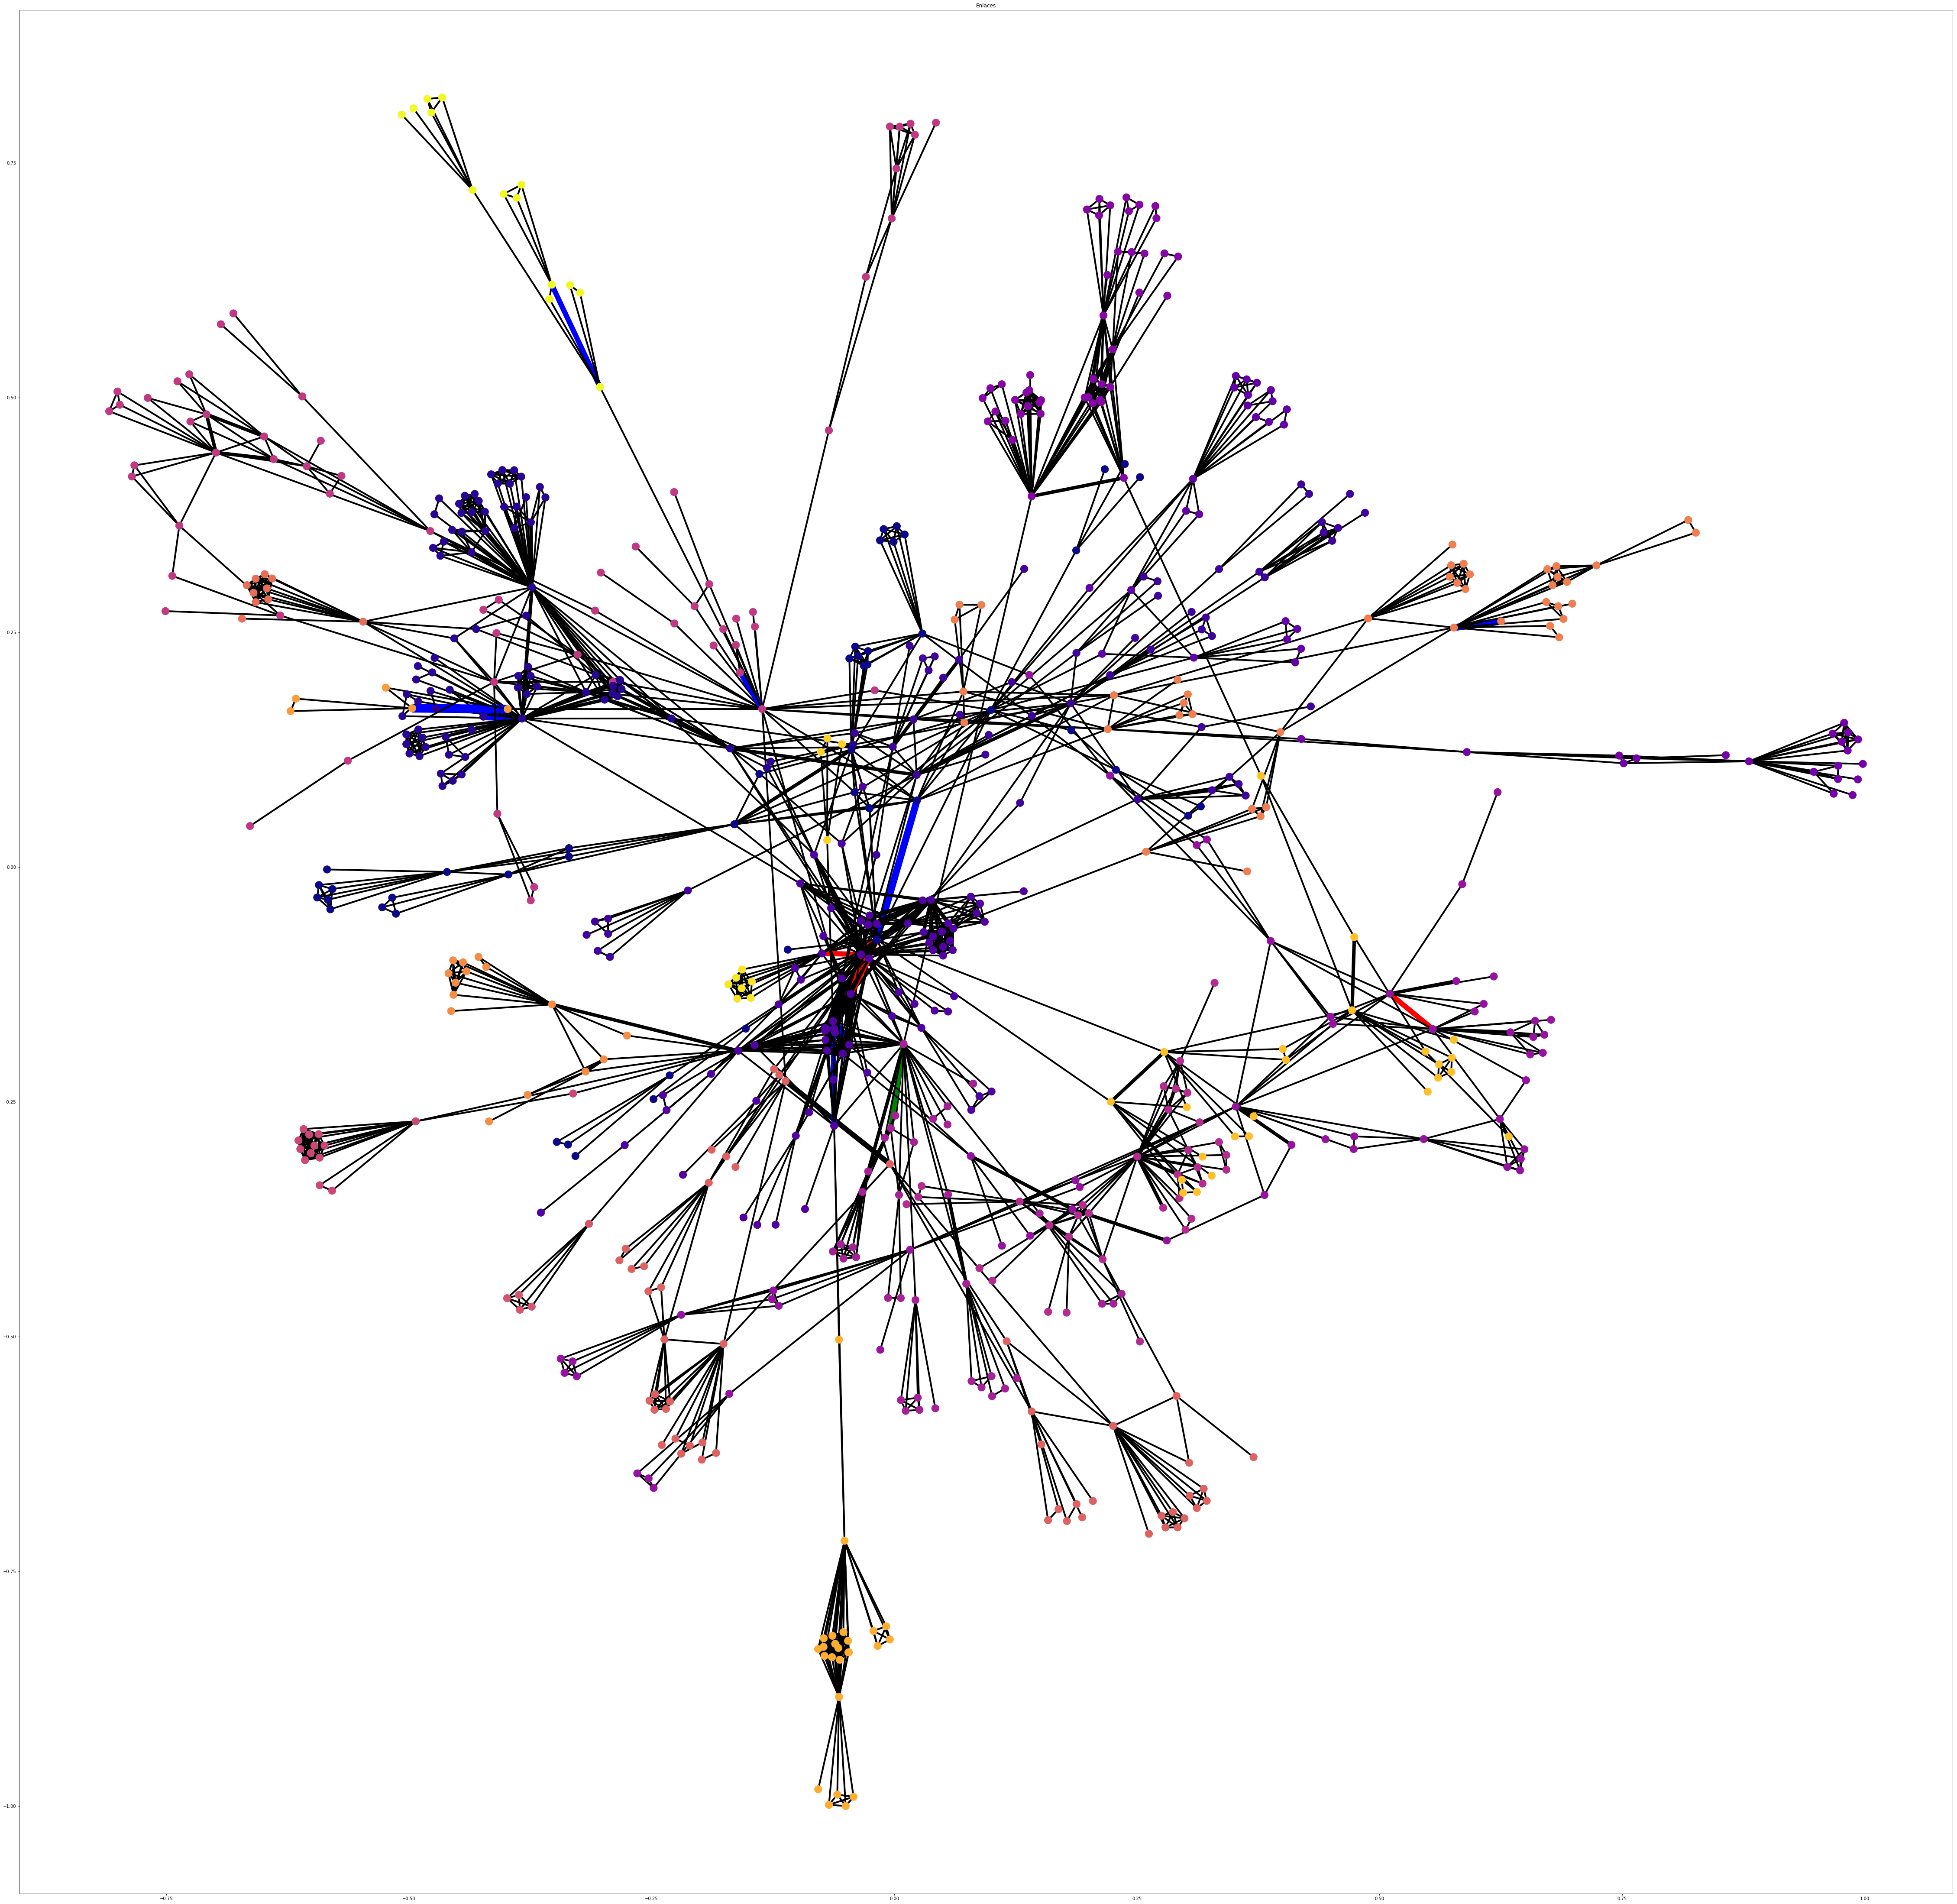

In [63]:
plt.figure(figsize=(80,80))
for name,label in comunidadesPP.items():
    PP.nodes()[name]["color"] = label

nx.draw_networkx(PP, nodelist=list(bet.keys()), 
#                  node_size=[v * 30000 for v in bet.values()],
                 cmap=plt.get_cmap('plasma'),
                 node_color=list(nx.get_node_attributes(PP,'color').values()),
                 edgelist=list(nx.get_edge_attributes(PP,'Color').keys()),
#                  edgelist=listaejes,
                 edge_color=list(nx.get_edge_attributes(PP,'Color').values()),
#                  edge_color=colorejes,
                 width=[t * 20/max(nx.get_edge_attributes(PP,'weight').values()) for t in nx.get_edge_attributes(PP,'weight').values()],
#                  edge_color=['blue' if list(nx.get_edge_attributes(PP,'weight').values())>=5],
#                  width=5,
                 with_labels=False)
plt.title('Enlaces')
# plt.savefig ("Particion_Louvain.png")
plt.show()

## Objetivo 1 BIS

In [64]:
rol_mayoritario = []
#Primer estimador permite ver aquellas personas que tuvieron un porcentaje de algún rol mayor al 50%
#Segundo estimador permite ver aquellas personas que no habiendo superado el 50% en ningún rol sin embargo estan por encima
#de otro valor. Alterando este segundo estimador podes observar el porcentaje de los otros roles.
# Para este ultimo comentario probar estimador2 = 0.49 y ver la persona 89, luego probar estimador2 = 0.30 y ver la misma
#persona.
# estimador1 = 0.70
# estimador2 = 0.30
estimador1 = 0.99
estimador2 = 0.01
for l in range (len(N_sos)):
    crim_tot = N_sos[l] + N_test[l] + N_vict [l] + N_dual[l]
    prop = [[N_sos[l]/crim_tot,'s'],[N_test[l]/crim_tot,'t'],[N_vict[l]/crim_tot,'v'],[N_dual[l]/crim_tot,'d']]
    if any (i[0] > estimador1 for i in prop) is True:
        for k in prop:
            if k[0] > estimador1:
                rol_mayoritario.append([str(l+1),[k[0],k[1]]])
    else:
        pers_rol = []
        for r in prop:
            if r[0] > estimador2:
                pers_rol.append (r)
        if len(pers_rol) == 1:
            rol_mayoritario.append([str(l+1),pers_rol[0]])
        else:
            rol_mayoritario.append ([str(l+1),pers_rol])
rol_mayoritario

[['1', [[0.5, 's'], [0.5, 'v']]],
 ['2',
  [[0.7727272727272727, 's'],
   [0.045454545454545456, 't'],
   [0.18181818181818182, 'v']]],
 ['3', [1.0, 's']],
 ['4', [1.0, 's']],
 ['5', [1.0, 'v']],
 ['6', [1.0, 'v']],
 ['7', [1.0, 's']],
 ['8', [1.0, 's']],
 ['9', [1.0, 'v']],
 ['10', [[0.5, 's'], [0.125, 't'], [0.25, 'v'], [0.125, 'd']]],
 ['11', [1.0, 'v']],
 ['12', [1.0, 'v']],
 ['13', [1.0, 'v']],
 ['14', [1.0, 'v']],
 ['15', [1.0, 's']],
 ['16', [1.0, 't']],
 ['17', [1.0, 's']],
 ['18', [1.0, 's']],
 ['19', [1.0, 's']],
 ['20', [1.0, 's']],
 ['21', [1.0, 'v']],
 ['22', [1.0, 'd']],
 ['23', [1.0, 's']],
 ['24', [1.0, 's']],
 ['25', [1.0, 's']],
 ['26', [1.0, 's']],
 ['27', [1.0, 'v']],
 ['28', [1.0, 'v']],
 ['29', [1.0, 's']],
 ['30', [1.0, 'v']],
 ['31', [1.0, 'v']],
 ['32', [1.0, 'v']],
 ['33', [1.0, 'v']],
 ['34', [1.0, 's']],
 ['35', [1.0, 's']],
 ['36', [1.0, 's']],
 ['37', [[0.75, 's'], [0.125, 't'], [0.125, 'v']]],
 ['38', [1.0, 's']],
 ['39', [1.0, 's']],
 ['40', [[0.5, 't'],

In [65]:
bet_rol = []
for i in range (20):
    persona = int (centrbet[i][0])
    bet_rol.append(rol_mayoritario[persona-1])   

#### Para red aleatoria

In [73]:
Nbet_rol = []

rol_aleatorio = copy.deepcopy(roles)

for i in range (10):
    random.shuffle(rol_aleatorio)
    N_sos = [] 
    N_test = []
    N_vict = []
    N_dual = []

    NS = 0
    NT = 0
    NV = 0
    ND = 0

    for i in range (1,len (data_total)):
        if data_total [i][0] == data_total [i-1][0]:
            if ["Suspect"] == rol_aleatorio [i-1]:
                NS = NS + 1
            elif  ['Witness'] == rol_aleatorio [i-1]:
                NT = NT + 1
            elif ['Victim'] == rol_aleatorio [i-1]:
                NV = NV + 1
            elif ['Victim', 'Suspect'] == rol_aleatorio [i-1]:
                ND = ND + 1

        elif data_total [i][0] != data_total [i-1][0]:

            if ["Suspect"] == rol_aleatorio [i-1]:
                NS = NS + 1
            elif  ['Witness'] == rol_aleatorio [i-1]:
                NT = NT + 1
            elif ['Victim'] == rol_aleatorio [i-1]:
                NV = NV + 1
            elif ['Victim', 'Suspect'] == rol_aleatorio [i-1]:
                ND = ND + 1
            N_sos.append(NS)
            N_test.append(NT)
            N_vict.append(NV)
            N_dual.append(ND)
            NS = 0
            NT = 0
            NV = 0
            ND = 0

        try:
            assert (i < (len (data_total)-1))
        except AssertionError:
            if ["Suspect"] == rol_aleatorio [i]:
                NS = NS + 1
            elif  ['Witness'] == rol_aleatorio [i]:
                NT = NT + 1
            elif ['Victim'] == rol_aleatorio [i]:
                NV = NV + 1
            elif ['Victim', 'Suspect'] == rol_aleatorio [i]:
                ND = ND + 1
            N_sos.append(NS)
            N_test.append(NT)
            N_vict.append(NV)
            N_dual.append(ND)
            
            
    rol_mayoritario = []
    estimador1 = 0.99
    estimador2 = 0.01
    for l in range (len(N_sos)):
        crim_tot = N_sos[l] + N_test[l] + N_vict [l] + N_dual[l]
        prop = [[N_sos[l]/crim_tot,'s'],[N_test[l]/crim_tot,'t'],[N_vict[l]/crim_tot,'v'],[N_dual[l]/crim_tot,'d']]
        if any (i[0] > estimador1 for i in prop) is True:
            for k in prop:
                if k[0] > estimador1:
                    rol_mayoritario.append([str(l+1),[k[0],k[1]]])
        else:
            pers_rol = []
            for r in prop:
                if r[0] > estimador2:
                    pers_rol.append (r)
            if len(pers_rol) == 1:
                rol_mayoritario.append([str(l+1),pers_rol[0]])
            else:
                rol_mayoritario.append ([str(l+1),pers_rol])
    
    
    bet_rol = []
    for i in range (20):
        persona = int (centrbet[i][0])
        bet_rol.append(rol_mayoritario[persona-1])          
    
    Nbet_rol.append (bet_rol)

In [74]:
Nbet_rol

[[['815', [[0.24, 's'], [0.24, 't'], [0.44, 'v'], [0.08, 'd']]],
  ['690',
   [[0.5714285714285714, 's'],
    [0.14285714285714285, 't'],
    [0.2857142857142857, 'v']]],
  ['2',
   [[0.6818181818181818, 's'],
    [0.09090909090909091, 't'],
    [0.22727272727272727, 'v']]],
  ['56',
   [[0.14285714285714285, 's'],
    [0.35714285714285715, 't'],
    [0.42857142857142855, 'v'],
    [0.07142857142857142, 'd']]],
  ['715',
   [[0.25, 's'],
    [0.16666666666666666, 't'],
    [0.5, 'v'],
    [0.08333333333333333, 'd']]],
  ['439', [1.0, 'v']],
  ['333', [[0.25, 's'], [0.25, 't'], [0.5, 'v']]],
  ['356',
   [[0.45454545454545453, 's'],
    [0.09090909090909091, 't'],
    [0.45454545454545453, 'v']]],
  ['425',
   [[0.3333333333333333, 's'],
    [0.1111111111111111, 't'],
    [0.5, 'v'],
    [0.05555555555555555, 'd']]],
  ['17', [[0.6, 's'], [0.4, 'v']]],
  ['424', [1.0, 's']],
  ['62', [[0.3333333333333333, 's'], [0.16666666666666666, 't'], [0.5, 'v']]],
  ['812', [[0.75, 's'], [0.25, 't'